In [1]:
## Preprocessing pipeline for all tracks

## 4. egocentrize
## 5. Normalize
## 6. PCA

import os
from rich.progress import track
from einops import rearrange
from tqdm import tqdm

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

joint_list = np.array([
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
])

In [2]:
data_path = "/scratch/gpfs/tt1131/rotation_project_spring/track_evaluation/data/"
m1_imp_rf_dict = np.load(os.path.join(data_path, "intact_track_impute_m1_cubic_rf_032023.npy"), allow_pickle=True).item()
m2_imp_rf_dict = np.load(os.path.join(data_path, "intact_track_impute_m2_cubic_rf_032023.npy"), allow_pickle=True).item()

In [3]:
m1_imp_rf_loc = [m1_imp_rf_dict[key] for key in m1_imp_rf_dict.keys()]
m1_imp_rf_nan = np.array([np.isnan(m1_imp_rf_loc[i]).sum() / (m1_imp_rf_loc[i].shape[0] * m1_imp_rf_loc[i].shape[1]) for i in range(len(m1_imp_rf_loc))])

m2_imp_rf_loc = [m2_imp_rf_dict[key] for key in m2_imp_rf_dict.keys()]
m2_imp_rf_nan = np.array([np.isnan(m2_imp_rf_loc[i]).sum() / (m2_imp_rf_loc[i].shape[0] * m2_imp_rf_loc[i].shape[1]) for i in range(len(m2_imp_rf_loc))])

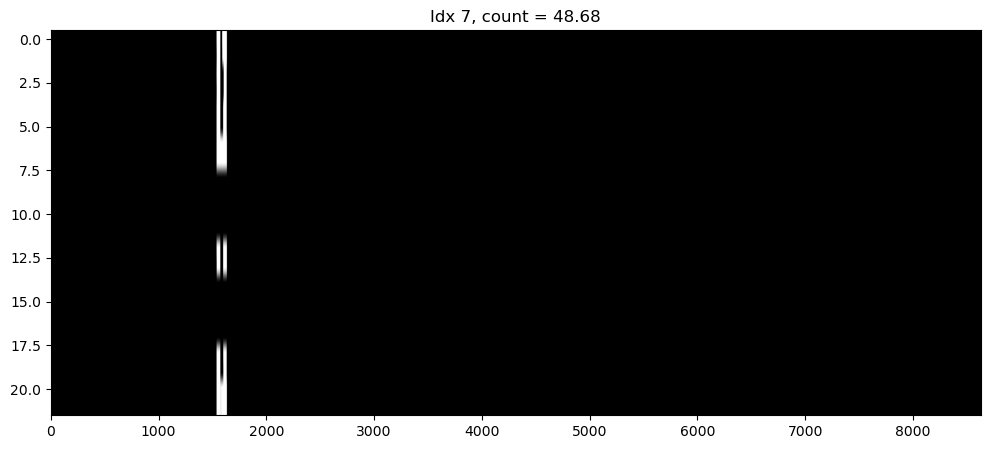

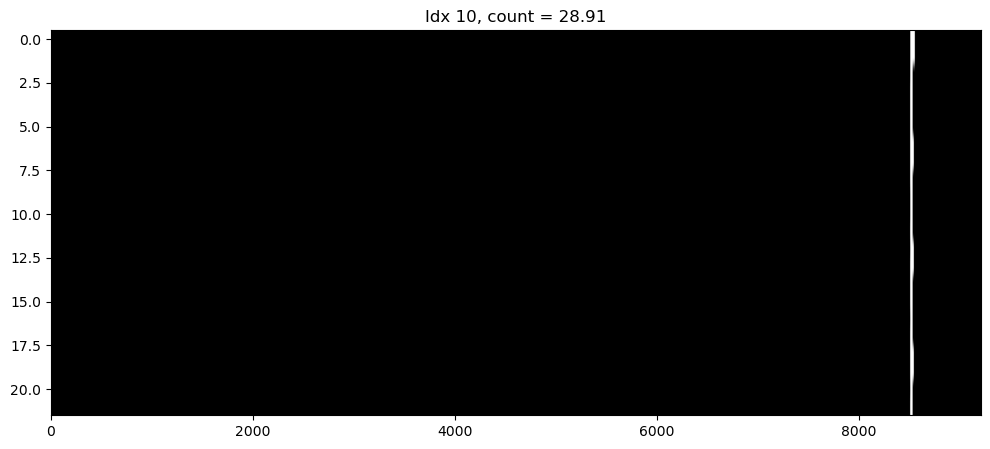

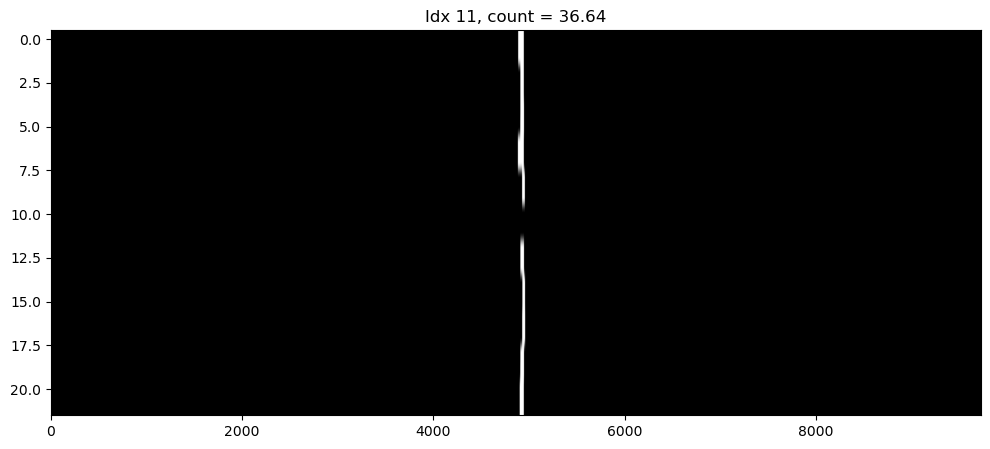

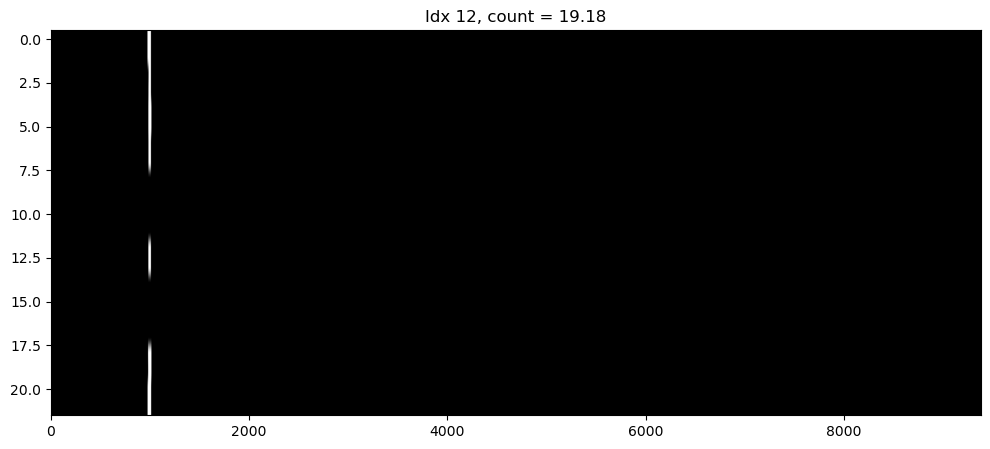

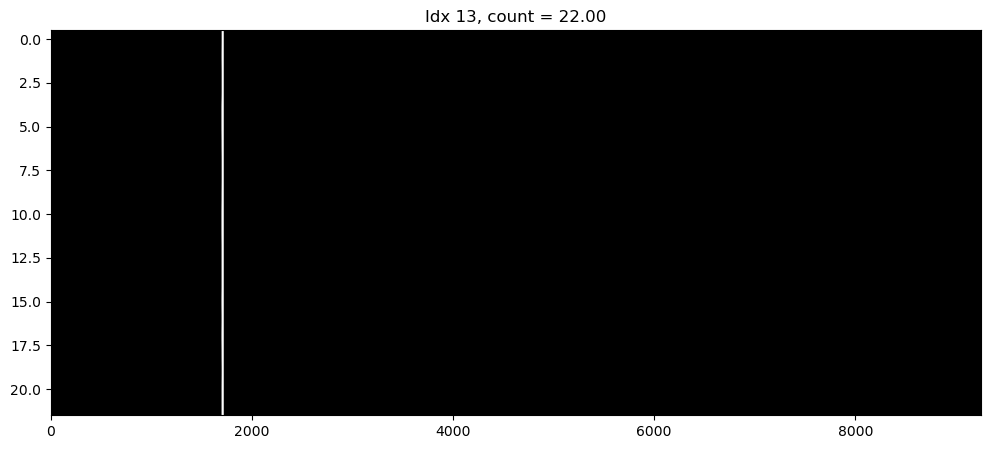

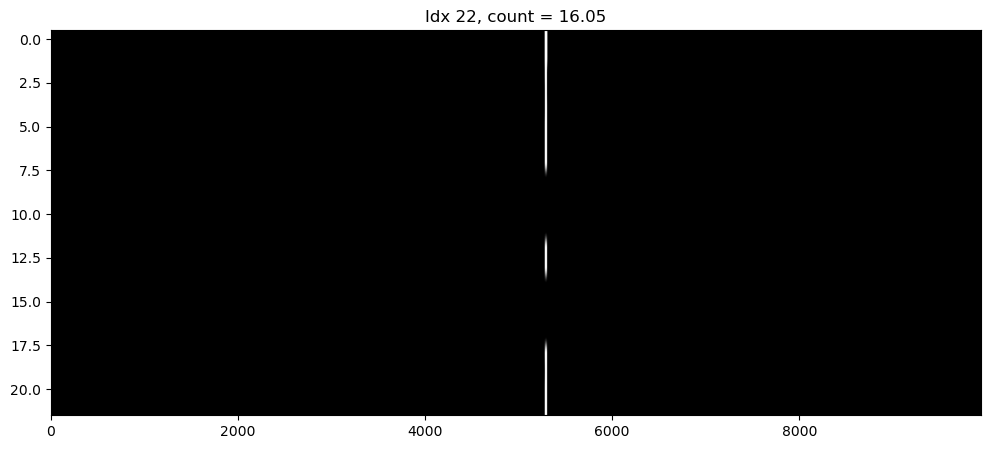

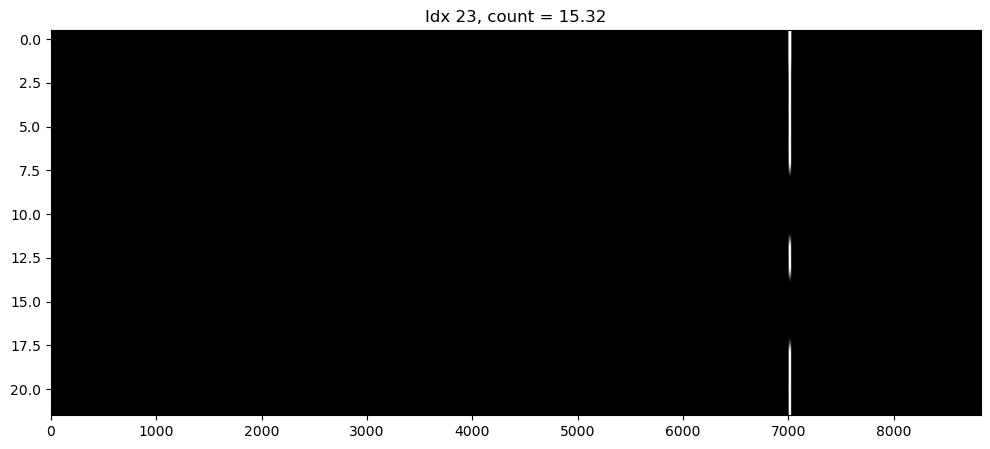

In [4]:
high_nans = np.where(m1_imp_rf_nan < np.quantile(m1_imp_rf_nan, .8))[0]
for idx in high_nans[:20]:
    if np.isnan(m1_imp_rf_loc[idx]).sum() > 0:
        fig, axs = plt.subplots(figsize = (12, 5))
        axs.imshow(np.where(np.isnan(m1_imp_rf_loc[idx]), 0, 1).T, aspect = "auto", cmap = "gray_r")
        axs.set_title(f"Idx {idx}, count = {np.isnan(m1_imp_rf_loc[idx]).sum() / 22 :.2f}")
        plt.show()
        plt.close(fig)

In [5]:
no_nan_idx = np.where(m1_imp_rf_nan == 0)[0]
print(no_nan_idx.shape)

no_nan_idx_m2 = np.where(m2_imp_rf_nan == 0)[0]
print(no_nan_idx_m2.shape)

selected_m1 = [m1_imp_rf_loc[idx] for idx in no_nan_idx]
selected_m2 = [m2_imp_rf_nan[idx] for idx in no_nan_idx_m2]


## Check if there is intersection
intersect_vid = np.intersect1d(np.array([*m1_imp_rf_dict.keys()])[no_nan_idx], np.array([*m2_imp_rf_dict.keys()])[no_nan_idx_m2])
print(len(intersect_vid))

(219,)
(172,)
97


In [6]:
## Further subset
m1_common_idx = []
m2_common_idx = []

m1_keys = np.array([*m1_imp_rf_dict.keys()])
m2_keys = np.array([*m2_imp_rf_dict.keys()])

for vid_key in intersect_vid:
    m1_common_idx.append(np.where(m1_keys == vid_key)[0][0])
    m2_common_idx.append(np.where(m2_keys == vid_key)[0][0])

common_selected_m1 = [rearrange(m1_imp_rf_loc[idx], "t (j d) -> t j d", j = 11, d = 2) for idx in m1_common_idx]
common_selected_m2 = [rearrange(m2_imp_rf_loc[idx],"t (j d) -> t j d", j = 11, d = 2) for idx in m2_common_idx]

In [7]:
## Do egocentrise here

THORAX_POS = 4
HEAD_POS = 1

def normalize_to_egocentric(
    x: np.ndarray,
    rel_to: Optional[np.ndarray] = None,
    ctr_ind: int = THORAX_POS,
    fwd_ind: int = HEAD_POS,
    return_angles: bool = False,
):
    """Normalize pose estimates to egocentric coordinates.
    Args:
        x: Pose of shape (joints, 2) or (time, joints, 2)
        rel_to: Pose to align x with of shape (joints, 2) or (time, joints, 2). Defaults
            to x if not specified.
        ctr_ind: Index of centroid joint. Defaults to MOUSE_CENTER_BACK.
        fwd_ind: Index of "forward" joint (e.g., head). Defaults to MOUSE_NECK.
        return_angles: If True, return angles with the aligned coordinates.
    Returns:
        Egocentrically aligned poses of the same shape as the input.
        If return_angles is True, also returns a vector of angles.
    """

    if rel_to is None:
        rel_to = x

    is_singleton = (x.ndim == 2) and (rel_to.ndim == 2)

    if x.ndim == 2:
        x = np.expand_dims(x, axis=0)
    if rel_to.ndim == 2:
        rel_to = np.expand_dims(rel_to, axis=0)

    # Find egocentric forward coordinates.
    ctr = rel_to[..., ctr_ind, :]  # (t, 2)
    fwd = rel_to[..., fwd_ind, :]  # (t, 2)
    ego_fwd = fwd - ctr

    # Compute angle.
    ang = np.arctan2(
        ego_fwd[..., 1], ego_fwd[..., 0]
    )  # arctan2(y, x) -> radians in [-pi, pi]
    ca = np.cos(ang)  # (t,)
    sa = np.sin(ang)  # (t,)

    # Build rotation matrix.
    rot = np.zeros([len(ca), 3, 3], dtype=ca.dtype)
    rot[..., 0, 0] = ca
    rot[..., 0, 1] = -sa
    rot[..., 1, 0] = sa
    rot[..., 1, 1] = ca
    rot[..., 2, 2] = 1

    # Center.
    x = x - np.expand_dims(ctr, axis=1)

    # Pad, rotate and crop.
    x = np.pad(x, ((0, 0), (0, 0), (0, 1)), "constant", constant_values=1) @ rot
    x = x[..., :2]

    if is_singleton:
        x = x[0]

    if return_angles:
        return x, ang
    else:
        return x

In [8]:
joints_connect = [
    [0, 1],
    [1, 2],
    [1, 3],
    [1, 4],
    [4, 5],
    [5, 7],
    [5, 8],
    [1, 9],
    [1, 10],
    [1, 6]
]

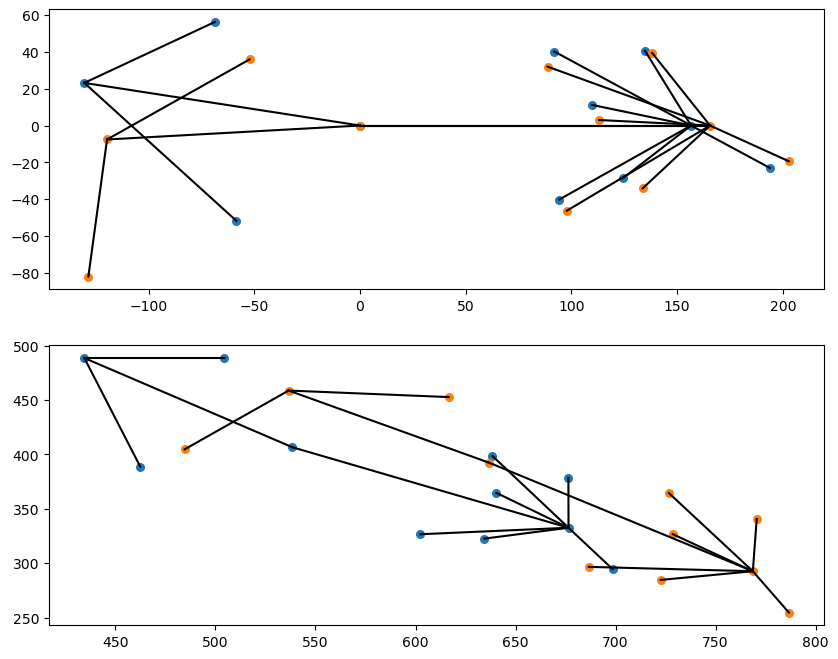

In [9]:
ego_m1 = normalize_to_egocentric(common_selected_m1[1])

fig, axs = plt.subplots(2, 1, figsize = (10, 8))
tidx = 0

axs[0].scatter(ego_m1[tidx, :, 0], ego_m1[tidx, :, 1], s = 30)
_  = axs[0].plot(ego_m1[tidx, joints_connect, 0].T, ego_m1[tidx, joints_connect, 1].T, c = "k")

axs[0].scatter(ego_m1[tidx + 5, :, 0], ego_m1[tidx + 5, :, 1], s = 30)
_  = axs[0].plot(ego_m1[tidx + 5, joints_connect, 0].T, ego_m1[tidx + 5, joints_connect, 1].T, c = "k")


axs[1].scatter(common_selected_m1[1][tidx, :, 0], common_selected_m1[1][tidx, :, 1], s = 30)
_  = axs[1].plot(common_selected_m1[1][tidx, joints_connect, 0].T, 
                 common_selected_m1[1][tidx, joints_connect, 1].T, c = "k")

axs[1].scatter(common_selected_m1[1][tidx + 5, :, 0], common_selected_m1[1][tidx + 5, :, 1], s = 30)
_  = axs[1].plot(common_selected_m1[1][tidx + 5, joints_connect, 0].T, 
                 common_selected_m1[1][tidx + 5, joints_connect, 1].T, c = "k")

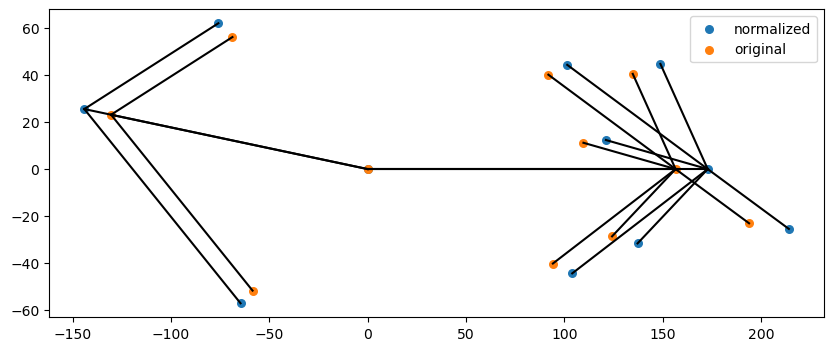

In [10]:
ego_m1 = [normalize_to_egocentric(i) for i in common_selected_m1]
ego_m2 = [normalize_to_egocentric(i) for i in common_selected_m2]

### Normalize each mice's length
head_to_tail_lengths = np.array([np.median(np.linalg.norm(m[:, 5] - m[:, 1], axis = 1)) for m in ego_m1])
head_to_tail_lengths_norm = head_to_tail_lengths / np.max(head_to_tail_lengths)

ego_m1_scaled = [m / scale for m, scale in zip(ego_m1, head_to_tail_lengths_norm)]

head_to_tail_lengths_m2 = np.array([np.median(np.linalg.norm(m[:, 5] - m[:, 1], axis = 1)) for m in ego_m2])
head_to_tail_lengths_norm_m2 = head_to_tail_lengths_m2 / np.max(head_to_tail_lengths_m2)

ego_m2_scaled = [m / scale for m, scale in zip(ego_m2, head_to_tail_lengths_norm_m2)]

fig, axs = plt.subplots(figsize = (10, 4))
tidx = 0

axs.scatter(ego_m1_scaled[1][tidx, :, 0], ego_m1_scaled[1][tidx, :, 1], s = 30, label = "normalized")
_  = axs.plot(ego_m1_scaled[1][tidx, joints_connect, 0].T, ego_m1_scaled[1][tidx, joints_connect, 1].T, c = "k")

axs.scatter(ego_m1[1][tidx, :, 0], ego_m1[1][tidx, :, 1], s = 30, label = "original")
_  = axs.plot(ego_m1[1][tidx, joints_connect, 0].T, 
                 ego_m1[1][tidx, joints_connect, 1].T, c = "k")

axs.legend()

In [11]:
## Do PCA and Factor analysis
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA, FactorAnalysis

## PCA first
n_comp = 15

pca_obj = PCA(n_components = n_comp, random_state = 42)
m1_pca = pca_obj.fit_transform(rearrange(np.concatenate(ego_m1_scaled), "t j d -> t (j d)"))

pca_obj_m2 = PCA(n_components = n_comp, random_state = 42)
m2_pca = pca_obj_m2.fit_transform(rearrange(np.concatenate(ego_m2_scaled), "t j d -> t (j d)"))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Text(0.5, 1.0, 'cumulative explained variance ratio for M1 and M2 after PCA')

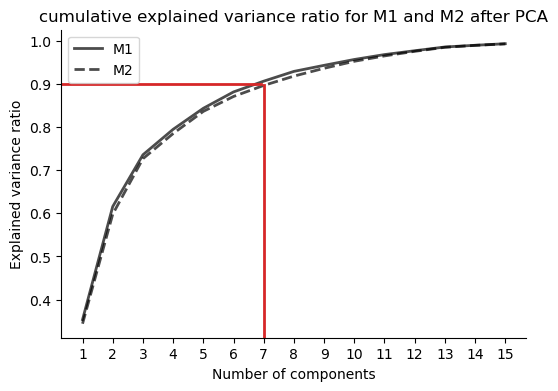

In [12]:
fig, axs = plt.subplots(figsize = (6, 4))
axs.plot(np.cumsum(pca_obj.explained_variance_ratio_), lw = 2, c = "k", alpha = .7, label = "M1")
axs.plot(np.cumsum(pca_obj_m2.explained_variance_ratio_), lw = 2, c = "k", alpha = .7, label = "M2", ls = "--")

axs.set_xlabel("Number of components")
axs.set_ylabel("Explained variance ratio")

axs.legend()

axs.axhline(.9, xmax = .43, c = "tab:red", lw = 2)
axs.axvline(6, ymax = .82, c = "tab:red", lw = 2)

_ = axs.set_xticks(np.arange(n_comp))
_ = axs.set_xticklabels(np.arange(1, n_comp + 1))
sns.despine()

axs.set_title("cumulative explained variance ratio for M1 and M2 after PCA")

In [13]:
## 1. subset the point scores

data_path = "/scratch/gpfs/tt1131/rotation_project_spring/track_evaluation/data/"
condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]
sample_dict = np.load(
    os.path.join(data_path, f"{condition_list[-1]}_track_dict_abrv.npy"),
    allow_pickle=True,
).item()

track_occupancy_list = []
locations_list = []
joint_scores_list = []

joint_list = np.array([
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "Tail_tip", "t0", "t1", "t2",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
])

omit_joints_idx = np.array([
    np.where(joint_list == "Tail_tip")[0][0],
    np.where(joint_list == "t0")[0][0],
    np.where(joint_list == "t1")[0][0],
    np.where(joint_list == "t2")[0][0]
])

joints_idx = np.array([i for i in range(len(joint_list)) if i not in omit_joints_idx])

joint_scores_list = []

## Sorting different data into tracks, also get rid of some of the tails tracking
for dict_key in sample_dict.keys():
    js = sample_dict[dict_key][5][:, joints_idx, :]
    joint_scores_list.append(js)

In [14]:
subset_joint_scores_m1 = [joint_scores_list[idx][:, :, 0] for idx in m1_common_idx]
subset_joint_scores_m2 = [joint_scores_list[idx][:, :, 1] for idx in m2_common_idx]

for m1_js, m2_js in zip(subset_joint_scores_m1, subset_joint_scores_m2):
    for f in range(m1_js.shape[1]):
        m1_js[:, f] = np.nan_to_num(m1_js[:, f], nan = np.nanmean(m1_js[:, f]))
        m2_js[:, f] = np.nan_to_num(m2_js[:, f], nan = np.nanmean(m2_js[:, f]))

In [15]:
m1_js_mean = np.concatenate(subset_joint_scores_m1)
m2_js_mean = np.concatenate(subset_joint_scores_m2)

assert np.isnan(m1_js_mean).sum() == 0
assert np.isnan(m2_js_mean).sum() == 0

m1_js_uncertainity = np.mean((m1_js_mean.max() - m1_js_mean) / m1_js_mean.max(), axis = 0)
m2_js_uncertainity = np.mean((m2_js_mean.max() - m2_js_mean) / m2_js_mean.max(), axis = 0)

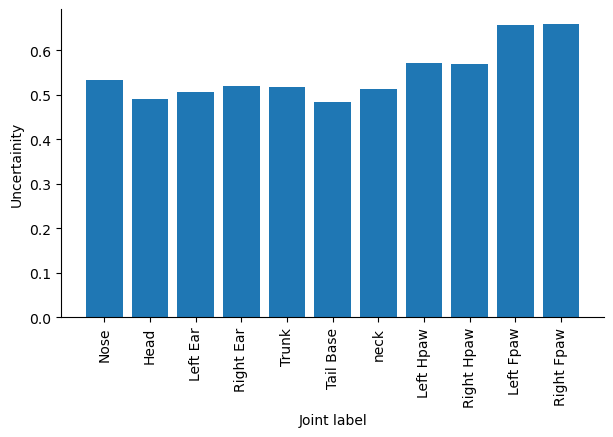

In [16]:
fig, ax = plt.subplots(figsize = (7, 4))
ax.bar(np.arange(len(m1_js_uncertainity)), 
       m1_js_uncertainity)
ax.set_xticks(np.arange(len(m1_js_uncertainity)))
ax.set_xticklabels(joint_list[joints_idx], rotation = 90)
ax.set_xlabel("Joint label")
ax.set_ylabel("Uncertainity")

sns.despine()

In [17]:
m1_noise = np.stack([m1_js_uncertainity, m1_js_uncertainity]).T.flatten()
m2_noise = np.stack([m2_js_uncertainity, m2_js_uncertainity]).T.flatten()

In [23]:
## Import standardscaler from sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
concat_m1 = rearrange(np.concatenate(ego_m1_scaled), "t j d -> t (j d)")

concat_m1_standard = scaler.fit_transform(concat_m1)

In [26]:
# FA_obj_m1_nonoise = FactorAnalysis(random_state = 42)
# m1_FA_sc_nonoise = FA_obj_m1_nonoise.fit_transform(concat_m1_standard)

# FA_obj_m1_nonoise = FactorAnalysis(random_state = 42)
# m1_FA_nonoise = FA_obj_m1_nonoise.fit_transform(concat_m1)

In [28]:
## Add the noise_variance_init to the FA through point scores

## 2. Fill the na with mean scores
## 3. (max - score) / max -> level of uncertainty

FA_obj_m1 = FactorAnalysis(random_state = 42, noise_variance_init = m1_noise)
m1_FA = FA_obj_m1.fit_transform(concat_m1)

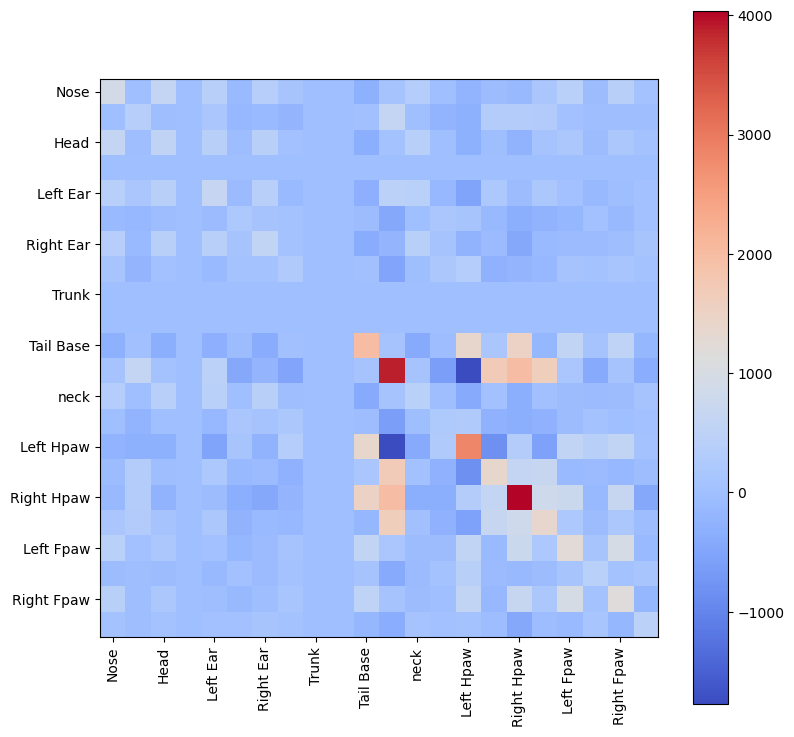

In [46]:
fig, ax = plt.subplots(figsize = (9, 9))

f = ax.imshow(FA_obj_m1.get_covariance(), cmap = "coolwarm")
_ = ax.set_xticks(np.arange(0, 22, 2))
_ = ax.set_xticklabels(joint_list[joints_idx], rotation = 90)

_ = ax.set_yticks(np.arange(0, 22, 2))
_ = ax.set_yticklabels(joint_list[joints_idx])
plt.colorbar(f)
